In [3]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import scipy.optimize as optimize
from iminuit import Minuit
import pandas as pd
import scipy.interpolate as interpolate
from scipy.integrate import quad
from matplotlib import colors
import uproot
import scipy.stats as st
from EBL_fit_MC_functions import *

Here we select the configuration:

In [4]:
fit_func_name = "PWL" # Function to fit. Possible options "MBPWL" (concave multiply broken power-law), "PWL" (Power-law), "LP" (concave Log-Parabola), "freeLP (Log-Parabola without concavity constraint)#Maybie more will be added in the future
Telescope = "CTAN_alpha" # Telescope to simulate. Possible options: "CTA_alpha", "MAGIC" (MAGIC does not work propperly yet)
Spectrum_func_name = "PWL" #Function for the simulated spectrum. POssible options: "PWL" , "LP" will be added soon but its not yet implemented.
EBL_Model = "Dominguez" #EBL model to test. Only "Dominguez" (Domínguez et al. 2011) is available at the moment.
Source_flux = 8.70e-6 # f0 flux of the source. Should be in m−2  s−1  TeV−1
Observation_time = 42480 #Observation time in seconds
niter = 1000 #number of iterations for the chi^2 vs alpha plot #The niter=1 has a different plot (just give it a try)

#for the chi² vs alpha plot:
initial_guess_pos = 1.25#1.5 #recommended values for MBPWL (>1.), for LP (<1.) (the chi² for alpha=initial_guess_pos if much worse than the other ones, will be fixed soon), for PWL (>1.)
step = 0.01 #0.05
last_bin = 1.25 #2.
first_bin = 0.75 #0.

#for PWL Spectrum function
if Spectrum_func_name == "PWL":
    Norm = 0.25 #Normalization Energy in TeV (Default 0.25)
    Ph_index = 2.03 #photon index for the power law (Default 2.03)

#for MBPWL as fit_function
if fit_func_name == "MBPWL":
    knots = 3 #Number of knots of the function. 3 is the default.
    initial_guess_0 = np.array([5e-7, 0, 0, 0, 0]) #initial guess of the MBPWL parameters: phi_0, lam1, deltas (len(deltas)=knots-2))
#for PWL
elif fit_func_name == "PWL":
    initial_guess_0 = np.array([5e-7, 2.]) #phi_0, gamma
#for LP and freeLP
elif fit_func_name == "LP" or fit_func_name == "freeLP":
    initial_guess_0 = np.array([5e-7, 2., 1.]) #phi_0, alpha, beta

Now we define the function and minimization depending on the previously selected fit function:

In [5]:
if fit_func_name != "MBPWL":
    knots = 0
fit_func = fit_func_select(fit_func_name, knots)
# if fit_func_name == "MBPWL":
#     def fit_func(xdata, params):
#         if knots < 2 or knots > 30: #change this when adding more number of knots
#             raise Exception('knots have to be larger or equal than 3 and smaller than 30')
#         else:
#             polw = np.zeros(len(xdata))
#             Ebr = np.geomspace(xdata[0], xdata[-1], knots+2)[1:-1]
#             gamma = np.zeros(knots+1)
#             phi = np.zeros(knots+1)
#             phi_0 = params[0] #len(sqrtdelta_lam) = len(lam)-1 = len(phi)-1
#             gamma0 = params[1]
#             sqrtdelta_gamma = params[2:knots+2]
#             delta_gamma = np.square(sqrtdelta_gamma)
#             gamma[0] = gamma0
#             phi[0] = phi_0
#             for i in range(knots):
#                 gamma[i+1] = gamma[i] + delta_gamma[i]
#                 phi[i+1] = phi[i] * Ebr[i] ** delta_gamma[i]
#             for i in range(len(xdata)):
#                 for j in range(knots):
#                     if xdata[i]<Ebr[0]:
#                         polw[i] = phi[0] * xdata[i] ** (-gamma[0])
#                     elif Ebr[-1] < xdata[i]:
#                         polw[i] = phi[-1] * xdata[i] ** (-gamma[-1])
#                     elif Ebr[j] <= xdata[i] < Ebr[j+1]:
#                         polw[i] = phi[j+1] * xdata[i] ** (-gamma[j+1])
#         return polw

# elif fit_func_name == "PWL":
#     def fit_func(xdata, params):
#         phi = params[0]
#         gamma = params [1]
#         PLW = phi * xdata ** (-gamma)
#         return PLW

# elif fit_func_name == "LP":
#     def fit_func(xdata, params):
#         phi0 = params[0]
#         alpha = params[1]
#         beta = params[2]
#         #Enorm = 1TeV #if it is 1 TeV no need ot include it (if it is different, need to add it to te LP function)
#         LP = phi0 * (xdata) ** (alpha - beta * beta * np.log(xdata))
#         return LP

# elif fit_func_name == "freeLP":
#     def fit_func(xdata, params):
#         phi0 = params[0]
#         alpha = params[1]
#         beta = params[2]
#         #Enorm = 1TeV #if it is 1 TeV no need ot include it (if it is different, need to add it to te LP function)
#         LP = phi0 * (xdata) ** (alpha - beta * np.log(xdata))
#         return LP


# else:
#     raise Exception('The function "{func}" has not been implemented.'.format(func = fit_func_name))

def LSQ(params):
    return np.sum((ydata - fit_func(xdata, params)) ** 2 / ydata_u ** 2)

def fit(initial_guess):
    #print('Warning: the shape of the parametes will depend on the number of knots (defined as knots)')
    #print('Warning: this will give the parameters of the fit and its errors which have to be put into the multiple_bpl function in order to get the fit')
    LSQ.errordef = Minuit.LIKELIHOOD

    m = Minuit(LSQ, initial_guess)
    #m.limits["initial_guess[2:-1]"] = (0,None)
    m.tol = 1e-20

    m.migrad()
    # print(m.values)

    #m.hesse()
    # print(m.errors)

    return m

Now let's load the EBL model

In [6]:
if EBL_Model == "Dominguez":
    file = np.loadtxt('tau_dominguez11.out')
    pdfile = pd.DataFrame(file)
    pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})
    E_EBL = pdfile['E [TeV]'].to_numpy()
    tau_EBL = pdfile['tau z=0.20842105'].to_numpy()
else:
    raise Exception('The EBL model "{func}" has not been implemented.'.format(func = EBL_Model))

Now we define the simulated spectrum function:

In [7]:
if Spectrum_func_name == "PWL":
    def dNdE_absorbed(K, E, Norm, Ph_index):
        dNdE = K / ((E/Norm)**Ph_index)
        m_tau = -tau_EBL
        return dNdE * np.exp(m_tau)

elif Spectrum_func_name == "LP":
    print("Not yet implemented")

else:
    raise Exception('The simulated spectrum "{func}" has not been implemented.'.format(func = Spectrum_func_name))

Now we load and treat the telescope performance files depending on the selected telescope:

In [8]:
if Telescope == "CTAN_alpha":
    
    #Effective area:
    fileEA = np.loadtxt('EffArea50h.txt', skiprows = 11)
    EffA = pd.DataFrame(fileEA)
    EffA = EffA.rename(columns={ 0 : 'E [TeV]', 1: 'Eff area (m^2)'})
    EffaE= EffA['E [TeV]'].to_numpy()
    Effa = EffA['Eff area (m^2)'].to_numpy()

    Effa_reb = normal_interp1d(EffaE, Effa, E_EBL[2:37])


    #Anglular resolution:
    fileAng = np.loadtxt('Angres.txt', skiprows = 11)
    Angresall = pd.DataFrame(fileAng)
    Angresall = Angresall.rename(columns={ 0 : 'E [TeV]', 1: 'Angular resolution (deg)'})
    AngresE = Angresall['E [TeV]'].to_numpy()
    Angres = Angresall['Angular resolution (deg)'].to_numpy()
    logE = np.log10(E_EBL)

    Angres_reb = log_interp1d(AngresE, Angres, E_EBL[2:37])

    #Background:
    fileBkg = np.loadtxt('Bkg50h.txt', skiprows = 10)
    Bkgpd = pd.DataFrame(fileBkg)
    Bkgpd = Bkgpd.rename(columns={ 0 : 'E_min (TeV)', 1: 'E_max (TeV)', 2: 'Bck Rate (Hz/deg^2)'})

    BckgEmin = Bkgpd['E_min (TeV)'].to_numpy()
    BckgEmax = Bkgpd['E_max (TeV)'].to_numpy()
    Bckg = Bkgpd['Bck Rate (Hz/deg^2)'].to_numpy()
    BckgEdiff = BckgEmax - BckgEmin

    BckgElogmean = np.power(10 ,np.mean([np.log10(BckgEmax), np.log10(BckgEmin)], axis = 0))

    Ebinsmin = np.zeros(len(E_EBL))
    Ebinsmax = np.zeros(len(E_EBL))

    for i in range(1, len(E_EBL)):
        Ebinsmin[i] = 10**(np.mean([np.log10(E_EBL[i]), np.log10(E_EBL[i-1])]))
    for i in range(len(E_EBL) - 1):
        Ebinsmax[i] = 10**(np.mean([np.log10(E_EBL[i]), np.log10(E_EBL[i+1])]))
        
    Ebinsmin[0] = 10**(np.log10(Ebinsmin[1])-(np.log10(Ebinsmin[2])-np.log10(Ebinsmin[1])))
    Ebinsmax[len(E_EBL)-1] = 10**(np.log10(Ebinsmax[len(E_EBL)-2])-(np.log10(Ebinsmax[len(E_EBL)-3])-np.log10(Ebinsmax[len(E_EBL)-2])))
    Ebinsw = Ebinsmax - Ebinsmin
    DifBckg = Bckg / (BckgEmax - BckgEmin) #Hz/deg**2

    interpolation_bckg = log_interp1d2(BckgElogmean,DifBckg)

    Bckg_reb = np.zeros([len(E_EBL[2:37]),2])
    for i in range(len(E_EBL[2:37])):
        Bckg_reb[i] = quad(interpolation_bckg, Ebinsmin[i+2], Ebinsmax[i+2])
    Bckg_reb = Bckg_reb[:,0]

    #Energy Resolution:
    fileEres = np.loadtxt('Eres.txt', skiprows = 8)
    Eresall = pd.DataFrame(fileEres)
    Eresall = Eresall.rename(columns={ 0 : 'E [TeV]', 1: 'Energy resolution (deg)'})
    EresE = Eresall['E [TeV]'].to_numpy()
    Eres = Eresall['Energy resolution (deg)'].to_numpy()

    Eres_reb = log_interp1d(EresE[:-1], Eres[:-1], E_EBL[2:37])
    Eres_reb2 = Eres_reb * E_EBL[2:37]

    #Treating the data:
    skyang = (180/np.pi)**2 * 2 * np.pi * (1-np.cos(np.deg2rad(Angres_reb)))#deg^2
    bckgmu = Bckg_reb * Observation_time * skyang

    ##Generating dNdE_absorved and applying Eres to it
    dNdEa = dNdE_absorbed(Source_flux, E_EBL, Norm, Ph_index)
    mu_vec = dNdEa[2:37] * Effa_reb * Ebinsw[2:37] * Observation_time


    logEbins = np.zeros(len(E_EBL[2:37])+1)
    for i in range(len(E_EBL[2:37])+1):
        if i == 0:
            logEbins[i] = logE[2] - ((logE[3]-logE[2])/2)
        elif i == (len(E_EBL[2:37])):
            logEbins[i] = logE[2:37][i-1] + ((logE[2:37][i-1]-logE[2:37][i-2])/2)
        else:
            logEbins[i] = (logE[2:37][i] + logE[2:37][i-1]) / 2

    Ebins = 10 ** logEbins

    mu_vec_reco = np.zeros(len(mu_vec))
    mu_vec_i = np.zeros(len(mu_vec))

    for i in range(len(mu_vec)):
        for j in range(len(mu_vec)):
            A = mu_vec[i]
            B = bckgmu[i]
            Em = Ebins[j]
            Ep = Ebins[j+1]
            sigma = Eres_reb2[i]
            mu = E_EBL[2:37][i]

            mu_vec_i[j] = Gauss_int(A, mu, sigma, Em, Ep)[0]
        mu_vec_reco = mu_vec_reco + mu_vec_i
    E_final = E_EBL[7:33]
    mu_vec_final = mu_vec_reco[5:-4]
    bckgmu_final = bckgmu[5:-4]
    Effa_final = Effa_reb[5:-4]
    Ebinsw_final = Ebinsw[7:33]
    tau = tau_EBL[7:33]

elif Telescope == "MAGIC":
    print("MAGIC not implemented yet")

else:
    raise Exception('The telescope "{func}" has not been implemented.'.format(func = Telescope))

In [9]:
if niter == 1:
    xdata = E_final    
    ydata, ydata_u, dNdE_b, dNdE_b_u = SED_gen(15, bckgmu_final, mu_vec_final, Effa_final, Ebinsw_final, Observation_time, xdata)

    things = fit(initial_guess = initial_guess_0)

    Egam = np.geomspace(E_final[1],E_final[-1], 300)

    plt.plot(Egam, fit_func(Egam, things.values), label='concave fit', color = 'orange')
    plt.errorbar(xdata, ydata, label='MC data',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
    plt.title("MC data and fit for EBL absorved spectrum")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r"$E$ ($TeV$)")
    plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
    plt.legend()
    plt.show()

    chisqs = []
    alphas = alphas_creation(initial_guess_pos, first_bin, last_bin, step)
    ydata, ydata_u = SED_alpha(initial_guess_pos, dNdE_b, dNdE_b_u, tau, E_final)
    things = fit(initial_guess=initial_guess_0)

    initial_guess_mat = ig_mat_create(fit_func_name, alphas, knots)
    initial_guess_mat[0] = things.values

    for i, alpha in enumerate(alphas):
        ydata, ydata_u = SED_alpha(alpha, dNdE_b, dNdE_b_u, tau, E_final)

        initial_guess = initial_guess_mat[i] #phi_0, lam1, deltas (len(deltas)=knots))
        if alpha == initial_guess_pos:
            initial_guess = initial_guess_mat [0]
        things = fit(initial_guess=initial_guess)
        if i < (len(alphas)):
            initial_guess_mat[i+1] = things.values
        chi2 = chisq(ydata, fit_func(E_final, things.values), ydata_u)
        chisqs.append(chi2)

        # if alpha == alphas[20] or alpha == alphas[24] or alpha == alphas[29]:  #This is used to plot the data+ the fit when there is some alpha value we need to see.
        #     plt.plot(xdata, fit_func(xdata, things.values), label='concave fit', color = 'orange')
        #     plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
        #     plt.xscale('log')
        #     plt.yscale('log')
        #     plt.xlabel(r"$E$ ($TeV$)")
        #     plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
        #     plt.legend()
        #     plt.show()

    plt.plot(alphas, chisqs, 'o')
    plt.yscale('log')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\chi^2$')
    # plt.ylim(0,200)
    plt.show()

    order = np.argsort(alphas)
    interpx = np.arange(first_bin, last_bin, step/5)
    alphas_reord = np.take_along_axis(alphas, order, axis=0)
    chisqs_reord = np.take_along_axis(np.array(chisqs), order, axis=0)
    f1 = interpolate.interp1d(alphas_reord, chisqs_reord, kind='linear')
    chis_new = f1(interpx)
    sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
    upper_bound_1s = step/5 * np.max(sigma_inter_1s)
    lower_bound_1s = step/5 * np.min(sigma_inter_1s)
    print("The minimum is at alpha = ", interpx[np.argmin(chis_new)], " + ", upper_bound_1s-interpx[np.argmin(chis_new)], " - ", interpx[np.argmin(chis_new)] - lower_bound_1s)
    sigma_inter_2s = np.where(chis_new <= 4 + np.min(chis_new))
    upper_bound_2s = step/5 * np.max(sigma_inter_2s)
    lower_bound_2s = step/5 * np.min(sigma_inter_2s)
    print("The 2 sigma interval is at alpha = ", interpx[np.argmin(chis_new)], " + ", upper_bound_2s-interpx[np.argmin(chis_new)], " - ", interpx[np.argmin(chis_new)] - lower_bound_2s)
    sigma_inter_3s = np.where(chis_new <= 9 + np.min(chis_new))
    upper_bound_3s = step/5 * np.max(sigma_inter_3s)
    lower_bound_3s = step/5 * np.min(sigma_inter_3s)
    print("The 3 sigma interval is at alpha = ", interpx[np.argmin(chis_new)], " + ", upper_bound_3s-interpx[np.argmin(chis_new)], " - ", interpx[np.argmin(chis_new)] - lower_bound_3s)
      
else:
    chisqs_iter = []
    alphas_iter = []

    for j in range(niter):
        xdata = E_final
        SED, SED_u, dNdE_b, dNdE_b_u = SED_gen(j, bckgmu_final, mu_vec_final, Effa_final, Ebinsw_final, Observation_time, E_final)
        chisqs = []
        alphas = alphas_creation(initial_guess_pos, first_bin, last_bin, step)
        ydata, ydata_u = SED_alpha(initial_guess_pos, dNdE_b, dNdE_b_u, tau, E_final)
        things = fit(initial_guess=initial_guess_0)
        initial_guess_mat = ig_mat_create(fit_func_name, alphas, knots)
        initial_guess_mat[0] = things.values

        for i, alpha in enumerate(alphas):
            ydata, ydata_u = SED_alpha(alpha, dNdE_b, dNdE_b_u, tau, E_final)
            initial_guess = initial_guess_mat[i] #phi_0, lam1, deltas (len(deltas)=knots))
            if alpha == initial_guess_pos:
                initial_guess = initial_guess_mat[0]
            things = fit(initial_guess=initial_guess)
            if i < (len(alphas)):
                initial_guess_mat[i+1] = things.values
            chi2 = chisq(ydata, fit_func(E_final, things.values), ydata_u)
            chisqs.append(chi2)
            # if alpha == 1.5 and j == 1:# or alpha == 0.15 or alpha == 0.9 or alpha == 1.:
            #     print(chi2)
            #     plt.plot(xdata, multiple_bpl(xdata, things.values), label='concave fit', color = 'orange')
            #     plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
            #     plt.xscale('log')
            #     plt.yscale('log')
            #     plt.xlabel(r"$E$ ($TeV$)")
            #     plt.ylabel(r"$E^2$ $dF/dE$ ($TeV$ $m^{-2}$ $s^{-1}$)")
            #     plt.legend()
            #     plt.show() 

        alphas_iter.append(alphas)
        chisqs_iter.append(chisqs)
        print("\033[2;31;43m iteration {iter} of {niter} finished \033[0;0m".format(iter = j+1, niter = niter))

 iteration 1 of 1000 finished 
 iteration 2 of 1000 finished 
 iteration 3 of 1000 finished 
 iteration 4 of 1000 finished 
 iteration 5 of 1000 finished 
 iteration 6 of 1000 finished 
 iteration 7 of 1000 finished 
 iteration 8 of 1000 finished 
 iteration 9 of 1000 finished 
 iteration 10 of 1000 finished 
 iteration 11 of 1000 finished 
 iteration 12 of 1000 finished 
 iteration 13 of 1000 finished 
 iteration 14 of 1000 finished 
 iteration 15 of 1000 finished 
 iteration 16 of 1000 finished 
 iteration 17 of 1000 finished 
 iteration 18 of 1000 finished 
 iteration 19 of 1000 finished 
 iteration 20 of 1000 finished 
 iteration 21 of 1000 finished 
 iteration 22 of 1000 finished 
 iteration 23 of 1000 finished 
 iteration 24 of 1000 finished 
 iteration 25 of 1000 finished 
 iteration 26 of 1000 finished 
 iteration 27 of 1000 finished 
 iteration 28 of 1000 finished 
 iteration 29 of 1000 finished 
 iteration 30 of 1000 finished 
 iteration 31 of 1000 finished 
 iteration 32 of 

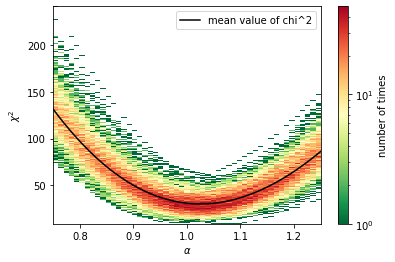

A 52.4 % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum
A 85.9 % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum
A 98.0 % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum
The median minimum is at alpha =  1.01  +  -0.708  -  0.766


In [10]:
#use this only if niter different to 1:
if niter == 1:
    raise Warning("You don't need this with 1 iteration")
else:
    chisqs_iter = np.array(chisqs_iter)
    alphas_iter = np.array(alphas_iter)
    alphas_iter2 = np.concatenate(alphas_iter)  #As the simulation takes long, the plot is made separately so one can change the plot without having to simulate everything again
    chisqs_iter2 = np.concatenate(chisqs_iter)
    order = np.argsort(alphas_iter[0])


    fig, ax = plt.subplots()
    ax.plot(np.take_along_axis(alphas_iter[0], order, axis=0), np.take_along_axis(np.mean(chisqs_iter,0), order, axis=0), color = "black", label="mean value of chi^2")
    h = ax.hist2d(alphas_iter2, chisqs_iter2, bins=[len(alphas_iter[0]),300], norm = colors.LogNorm(), cmap = "RdYlGn_r", label="histogram of chi^2 values")
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\chi^2$')
    ax.legend()
    # ax.set_ylim(0,200)
    # ax.set_xlim(0.5,1.15)
    fig.colorbar(h[3], ax=ax, label="number of times")
    plt.show()

    sigma_1 = []
    sigma_2 = []
    sigma_3 = []
    s1 = 0
    s2 = 0
    s3 = 0
    for i in range(len(alphas_iter)):
        sigma_1_0 = np.where(chisqs_iter[i] <= 1 + np.min(chisqs_iter[i]))
        sigma_2_0 = np.where(chisqs_iter[i] <= 4 + np.min(chisqs_iter[i]))
        sigma_3_0 = np.where(chisqs_iter[i] <= 9 + np.min(chisqs_iter[i]))
        sigma_1.append(sigma_1_0)
        sigma_2.append(sigma_2_0)
        sigma_3.append(sigma_3_0)
        number = np.where(np.round(alphas, decimals = 2) == 1)
        if number in sigma_1_0[0]: #this number is the position of the alpha=1 inside the alhpas array
            s1 += 1
        if number in sigma_2_0[0]:
            s2 += 1
        if number in sigma_3_0[0]:
            s3 += 1
    # print(sigma_1)
    # print(sigma_2)
    # print(sigma_3)
    print("A {sig} % of the simulations have the true value alpha=1 inside the 1 sigma interval around the minimum".format( sig = np.round(s1 / niter * 100, decimals = 3)))
    print("A {sig} % of the simulations have the true value alpha=1 inside the 2 sigma interval around the minimum".format( sig = np.round(s2 / niter * 100, decimals = 3)))
    print("A {sig} % of the simulations have the true value alpha=1 inside the 3 sigma interval around the minimum".format( sig = np.round(s3 / niter * 100, decimals = 3)))
    # print("The median minimum is at alpha={minimum}".format(minimum = alphas[np.argmin(np.median(chisqs_iter,0))]))

    order = np.argsort(alphas_iter[0])
    interpx = np.arange(first_bin, last_bin, step/5)
    alphas_reord = np.take_along_axis(np.median(alphas_iter, 0), order, axis=0)
    chisqs_repord = np.take_along_axis(np.median(chisqs_iter, 0), order, axis=0)
    f1 = interpolate.interp1d(alphas_reord, chisqs_repord, kind='linear')
    chis_new = f1(interpx)
    sigma_inter_1s = np.where(chis_new <= 1 + np.min(chis_new))
    upper_bound_1s = step/5 * np.max(sigma_inter_1s)
    lower_bound_1s = step/5 * np.min(sigma_inter_1s)
    # print("The 1 sigma upper bound is: ", upper_bound_1s, "and the lower bound is: ", lower_bound_1s)
    print("The median minimum is at alpha = ", np.round(interpx[np.argmin(chis_new)], decimals = 2), " + ", np.round(upper_bound_1s-interpx[np.argmin(chis_new)], decimals = 4), " - ", np.round(interpx[np.argmin(chis_new)] - lower_bound_1s, decimals = 4))
